# Overfitting and Regularization

## Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error
from sklearn import set_config

In [20]:
import warnings
warnings.filterwarnings('ignore')
set_config(display='diagram')

## Part 3: Homework assignment (10 points)

**WARNING!**

Due to the limited power of your machine, you may face some difficulties in generating polynomial features of a high degree. It's ok to take only a subsample of features for that purpose (even one feature is enough). Afterwards, you **must collect all features together** (those which were used to generate polynomials and the rest).

### Excercise 1 - Overfiting and Underfitting (2 points)

Определим настройки

In [4]:
SEED = 42
DEGREES = np.linspace(1, 15, 15, dtype=int)
ALPHAS = np.linspace(0, 0.5, 1 + 40)

Загрузим датасет, и преобразуем данные в float32 вместо float64

In [5]:
from sklearn.datasets import load_diabetes
data = load_diabetes()
X_diabetes = pd.DataFrame(
    data['data'], columns=data['feature_names']).astype('float32')
y_diabetes = pd.DataFrame(data['target'], columns=['target']).astype('float32')
# print(data['DESCR'])
display(X_diabetes.head(5))
y_diabetes.head(5)


,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022692,-0.009362
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031991,-0.046641


,target
0,151.0
1,75.0
2,141.0
3,206.0
4,135.0


Разделим данные на тренировочные и данные для валидации.

In [6]:
X_train_D, X_valid_D, y_train_D, y_valid_D = train_test_split(
    X_diabetes, y_diabetes, test_size=0.3, random_state=SEED)

Установим количество пареметров для полимеризации возьмем 5( первые 5 штук)

In [7]:

feats = ['age', 'sex', 'bmi', 'bp', 's1']

In [8]:
def make_model(degree, alpha=0, penalty=None):
    # linear regression
    if alpha == 0:
        regressor = LinearRegression()
    # lasso regression",
    elif penalty == 'L1':
        regressor = Lasso(alpha=alpha, random_state=SEED,
                          max_iter=10000, tol=1e-2)
    # ridge regression",
    elif penalty == 'L2':
        regressor = Ridge(alpha=alpha, random_state=SEED,
                          max_iter=10000, tol=1e-2)

    return Pipeline([
        ('trans', ColumnTransformer(transformers=[('pol', PolynomialFeatures(degree, include_bias=(degree == 0)), feats)], remainder='passthrough')),
        ('sca', StandardScaler()),
        ('reg', regressor)
    ])

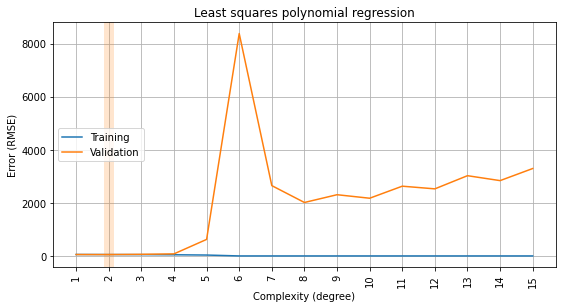

In [9]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def plot_fitting_graph(x, metric_train, metric_valid, xlabel, ylabel, 
                       custom_metric=None, custom_label='', custom_scale='log', title='Fitting graph'):
    plt.figure(figsize=(9, 4.5))
    plt.plot(x, metric_train, label='Training')
    plt.plot(x, metric_valid, color='C1', label='Validation')
    plt.axvline(x[np.argmin(metric_valid)], color='C1', lw=10, alpha=0.2)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.xticks(x, rotation='vertical')
    plt.legend(loc='center left')        
    if custom_metric:
        plt.twinx()
        plt.yscale(custom_scale)
        plt.plot(x, custom_metric, alpha=0.2, lw=4, ls='dotted', color='black', label=custom_label) 
        plt.legend(loc='center right')         
    plt.show()

rmse_train, rmse_valid = [], []
for degree in DEGREES:
    reg = make_model(degree).fit(X_train_D, y_train_D)
    rmse_train.append(rmse(reg.predict(X_train_D), y_train_D))
    rmse_valid.append(rmse(reg.predict(X_valid_D), y_valid_D))
plot_fitting_graph(DEGREES, rmse_train, rmse_valid, xlabel='Complexity (degree)', ylabel='Error (RMSE)',
                    title='Least squares polynomial regression')


In [10]:
DEGREES[np.argmin(rmse_valid)]

2

Выводы:

1. При степени полинома 2 модель получается оптимальной.
2. Степень более 2 приводит к переобучению, что явно видно из графиков среднеквадратичной ошибки для тестовых и тренировочных данных, так как ошибка на тренировочной модели возрастает и в дальнейшем с увеличением степени тенденция к ее уменьшению отсутствует.
3. При степени 1 модель недотренированна.
Однако данные данные нельзя принимать за обьективные так как:
1 - мы взяли для полимеризации не все параметры
2 - обьем выборки небольшой поэтому следует провести кросс валидацию что бы избавиться от влияния случайных факторов  на данные тренировочной и тестовой выборок и получить среднее значение, что будет сделано ниже.

Возьмем большее количество параметров

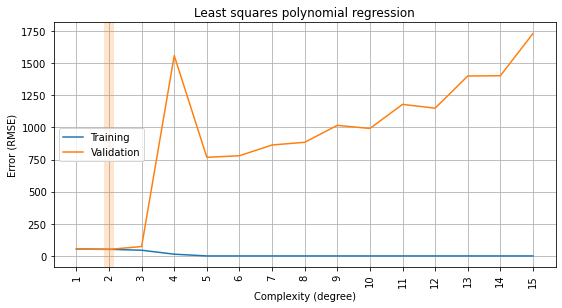

In [11]:
feats = ['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3']
rmse_train, rmse_valid = [], []
for degree in DEGREES:
    reg = make_model(degree).fit(X_train_D, y_train_D)
    rmse_train.append(rmse(reg.predict(X_train_D), y_train_D))
    rmse_valid.append(rmse(reg.predict(X_valid_D), y_valid_D))
plot_fitting_graph(DEGREES, rmse_train, rmse_valid, xlabel='Complexity (degree)', ylabel='Error (RMSE)',
                   title='Least squares polynomial regression')


Но так как время выполнения расчета растет не линейно, то остановимся на 5 параметрах.

In [12]:
feats = ['age', 'sex', 'bmi', 'bp', 's1']

Применим кросс валидацию для нашей модели.

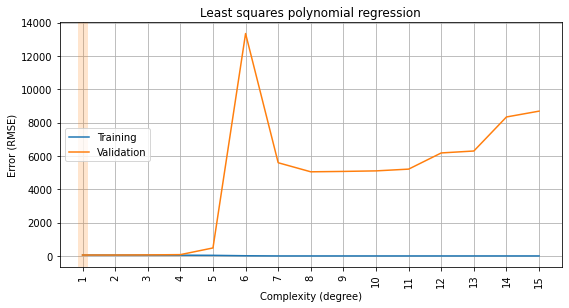

In [13]:
rmse_train, rmse_valid = [], []
for degree in DEGREES:
    results = cross_validate(make_model(degree),
                             X_diabetes, y_diabetes, cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))

plot_fitting_graph(DEGREES, rmse_train, rmse_valid, xlabel='Complexity (degree)', ylabel='Error (RMSE)',
                   title='Least squares polynomial regression')


Выводы:

После применения кросс валидации у нас изменилась степень при которой модель можно считать оптимальной. Степень снизилась до 1. Что можно считать существенным, так как на больших данных это позволит экономить время вычисления.  


### Excercise 2 - Magnitude (3 points)

As discussed earlier, regularization methods are expected to constraint the weights (model coefficients). 

Is it indeed happening? 

Please do a discovery on your own and find that out empirically (both for **L1** and **L2**). Let's use `degree=15` and `alpha` from `ALPHAS`.

Уменьшим количество параметров для полиномизации

In [14]:
feats = ['age', 'sex', 'bmi', 'bp', 's1']


Построим график зависимости среднего значения коэффициентов от степени полинома для обычной модели линейной регрессии

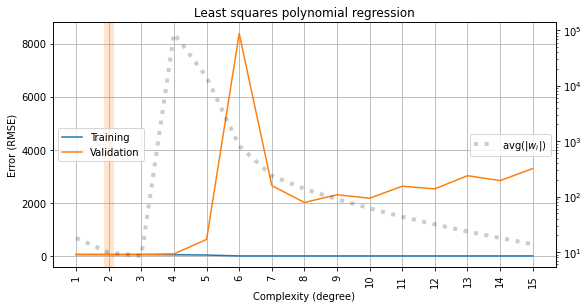

In [15]:
rmse_train, rmse_valid, mean_coef = [], [], []
for degree in DEGREES:
    reg = make_model(degree=degree).fit(X_train_D, y_train_D)
    rmse_train.append(rmse(reg.predict(X_train_D), y_train_D))
    rmse_valid.append(rmse(reg.predict(X_valid_D), y_valid_D))
    mean_coef.append(np.mean(np.abs(reg['reg'].coef_)))

plot_fitting_graph(DEGREES, rmse_train, rmse_valid,
                   xlabel='Complexity (degree)', ylabel='Error (RMSE)',
                   custom_metric=mean_coef, custom_label='avg(|$w_i$|)',
                   title='Least squares polynomial regression')


На выбранных параметрах среднее значение коэффициентов уменьшается  и при degree=15 имеет порядок $10^1$

#### L1

Построим график зависимости среднего значения коэффициентов от степени полинома для L1 и L2

C:\Users\slobbery.GBAS\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.548e+04, tolerance: 1.900e+04
  model = cd_fast.enet_coordinate_descent(
C:\Users\slobbery.GBAS\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.208e+04, tolerance: 1.900e+04
  model = cd_fast.enet_coordinate_descent(


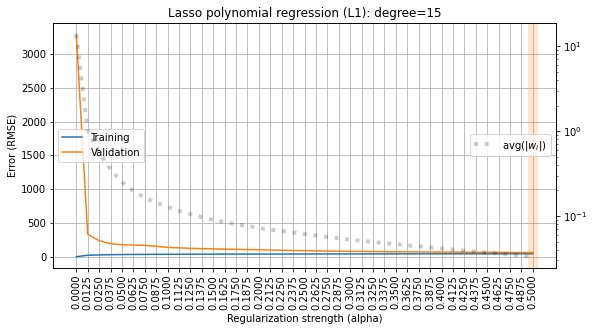

In [16]:
rmse_train, rmse_valid, mean_coef = [], [], []
for alpha in ALPHAS:
    reg = make_model(degree=15, penalty='L1',
                     alpha=alpha).fit(X_train_D, y_train_D)
    rmse_train.append(rmse(reg.predict(X_train_D), y_train_D))
    rmse_valid.append(rmse(reg.predict(X_valid_D), y_valid_D))
    mean_coef.append(np.mean(np.abs(reg['reg'].coef_)))
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid, xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   custom_metric=mean_coef, custom_label='avg(|$w_i$|)',
                   title='Lasso polynomial regression (L1): degree=15')


#### L2

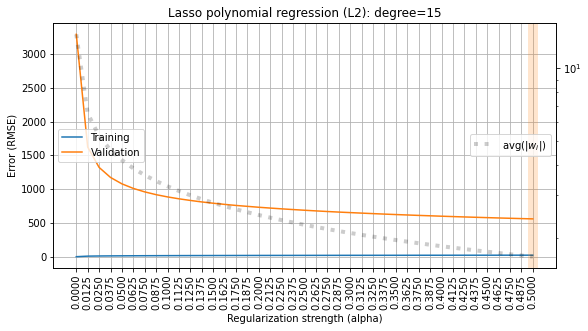

In [21]:
rmse_train, rmse_valid, mean_coef = [], [], []
for alpha in ALPHAS:
    reg = make_model(degree=15, penalty='L2',
                     alpha=alpha).fit(X_train_D, y_train_D)
    rmse_train.append(rmse(reg.predict(X_train_D), y_train_D))
    rmse_valid.append(rmse(reg.predict(X_valid_D), y_valid_D))
    mean_coef.append(np.mean(np.abs(reg['reg'].coef_)))
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid, xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   custom_metric=mean_coef, custom_label='avg(|$w_i$|)',
                   title='Lasso polynomial regression (L2): degree=15')


#### Summary

Из графиков видно что среднее значение коэффициентов при использовании L1 и L2 уменьшается быстрее чем при использовании обычной линейной регрессии

### Excercise 3 - Sparsity (3 points)

Lasso can also be used for **feature selection** since L1 is [more likely to produce zero coefficients](https://explained.ai/regularization/).

Is it indeed happening? 

Please do a discovery on your own and find that out empirically (both for **L1** and **L2**). Let's use `degree=15` and `alpha` from `ALPHAS`.

#### L1

In [22]:
zero_count_L1 = []
for alpha in ALPHAS:
    reg = make_model(degree=15, penalty='L1',
                     alpha=alpha).fit(X_train_D, y_train_D)
    zero_count_L1.append(
        (len(np.array(reg['reg'].coef_.flat)) - np.count_nonzero(reg['reg'].coef_)))

#### L2

In [23]:
zero_count_L2 = []
for alpha in ALPHAS:
    reg = make_model(degree=15, penalty='L2',
                     alpha=alpha).fit(X_train_D, y_train_D)
    zero_count_L2.append(
        (len(np.array(reg['reg'].coef_.flat)) - np.count_nonzero(reg['reg'].coef_)))


0

<AxesSubplot:xlabel='alphas', ylabel='value'>

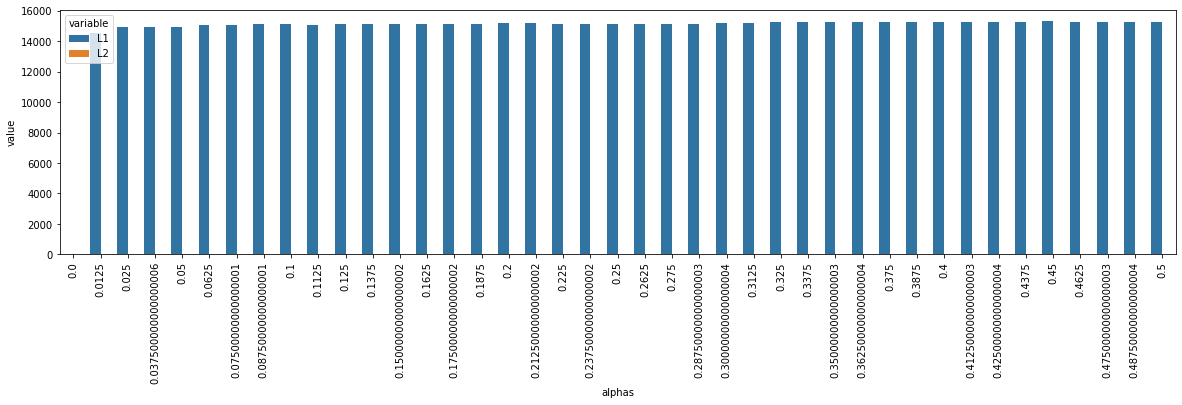

In [40]:
data = pd.DataFrame({'alphas': ALPHAS, 'L1': zero_count_L1, 'L2':zero_count_L2})
display(data['L2'].sum())
df = data.reset_index(drop=True).melt(id_vars='alphas')
plt.figure(figsize=(20, 4.5))
plt.xticks(df['alphas'], rotation='vertical')
sns.barplot(x='alphas', y='value', hue='variable', data=df)


#### Summary

Из графиков можно заметить что L1 позволяет занулять коэффициенты для параметров тем самым отбрасывая несущественные, L2 такого свойства не имеет.
Причем в моем случае зануление присходит с начала и очень сильно (alpha = 0.0125) и при этом количество нулевых весов сильно не увеличивается с увеличением alpha

### Excercise 4 - Scaling (2 points)

4 ЗАДАНИЕ НЕ ДЕЛАЛ!!!!!

As a general rule, it is recommended to scale input features before fitting a regularized model so that the features/inputs take values in similar ranges. One common way of doing so is to standardize the inputs and that is exactly what our pipeline  second step (`StandardScaler`) is responsible for. 

Is scaling important? What are the underlying reasons?

Please do a discovery on your own and find that out empirically (both for **L1** and **L2**) on the dataset below. Check coefficients.

In [42]:
RANGE = (-5, 5)
N_SAMPLES = 50

def target_function_hw(x):
    return 2 * x

def generate_samples_hw():
    np.random.seed(SEED)
    x = np.random.uniform(*RANGE, size=N_SAMPLES)
    
    np.random.seed(SEED+1)
    x_noise = np.random.uniform(*[x * 100 for x in RANGE], size=N_SAMPLES)
    x_noise2 = np.random.normal(100, 50, size=N_SAMPLES)
    
    y = target_function_hw(x) + np.random.normal(scale=4, size=N_SAMPLES)
    
    return np.concatenate([x.reshape(-1, 1) / 100, 
                           x_noise.reshape(-1, 1),
                           x_noise2.reshape(-1, 1)], axis=1), y

X_hw, y_hw = generate_samples_hw()

for i in range(X_hw.shape[1]):
    print(f'Min of feature {i}: {min(X_hw[:, i]):.2f}, max: {max(X_hw[:, i]):.2f}')

Min of feature 0: -0.05, max: 0.05
Min of feature 1: -494.87, max: 493.57
Min of feature 2: -2.35, max: 213.31


#### L1

In [ ]:
## your code

#### L2

In [ ]:
## your code

#### Summary



In [ ]:
## your observations/conclusions